**MPPI Optimization Loop Demo**

# **Installations**

In [ ]:
## Colab users ##

# Clone the repository
import os

git_path = '/content/balloon-outreach'
if os.path.exists(git_path):
    print("✅ Found:", git_path)
else:
    print("❌ Not found:", git_path)
    !git clone https://github.com/sdean-group/balloon-outreach.git
    %cd balloon-outreach
    !git checkout main

Cloning into 'balloon-outreach'...
remote: Enumerating objects: 1218, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 1218 (delta 40), reused 41 (delta 16), pack-reused 1130 (from 2)
Receiving objects: 100% (1218/1218), 84.57 MiB | 39.52 MiB/s, done.
Resolving deltas: 100% (756/756), done.
/content/balloon-outreach
Already on 'main'
Your branch is up to date with 'origin/main'.


In [ ]:
# Install required packages
!pip install -r requirements.txt
!pip install -U gdown

# **Sampling Demo**

Below is a walkthrough of one iteration of the MPPI optimization loop for a given control sequence:

In [78]:
import os
import sys
import numpy as np

os.chdir('/content/balloon-outreach')
sys.path.append('/content/balloon-outreach')

from env.balloon_env import BalloonEnvironment
from agent.mppi_agent import MPPIAgent
from env.visualize import plot_accs_vels_samples, plot_alts_movement_samples, plot_vels_averaged, plot_costs_samples
import matplotlib.pyplot as plt

initial_lat = 0
initial_lon = 0
initial_alt = 10.0
target_lat = 1
target_lon = 1
target_alt = 12
horizon = 30
num_samples = 10
acc_bounds = -0.5,0.5
env = BalloonEnvironment(target_lat=target_lat, target_lon=target_lon,target_alt=target_alt,dt=600)
agent = MPPIAgent(horizon=horizon,num_samples=num_samples, acc_bounds=acc_bounds, visualize=False)


control_sequence = np.zeros(horizon) # our plan of velocities for the balloon

# 1. Sample random control sequences
vertical_velocity = env.balloon.vertical_velocity
base_sequence = control_sequence.copy()
# Add noise from a Normal distribution to create samples
noise = np.random.normal(0, agent.noise_std, (agent.num_samples, agent.horizon))

acc_samples = base_sequence + noise
acc_samples = np.clip(acc_samples, agent.acc_bounds[0], agent.acc_bounds[1])

accumulated_acc_samples = np.cumsum(acc_samples, axis=1)
vel_samples = vertical_velocity + accumulated_acc_samples

# Clip to action bounds
vel_samples = np.clip(vel_samples, agent.vel_bounds[0], agent.vel_bounds[1])


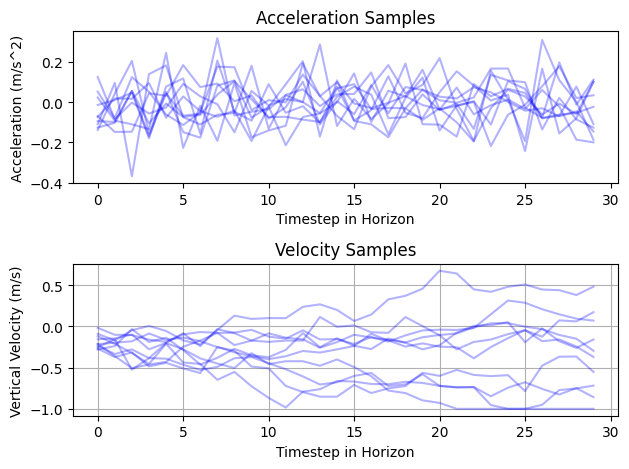

In [79]:
plot_accs_vels_samples(acc_samples, vel_samples, horizon)

In [80]:
# Use sampled vertical velocities to track horizontal and vertical movement
vert_movement = []
lateral_movement = []
for sample in vel_samples:
  alts = []
  paths = []
  alts.append(env.balloon.alt)
  paths.append((env.balloon.lon, env.balloon.lat))
  for action in sample:
    state, reward, done, reason = env.step(action)
    alts.append(env.balloon.alt)
    paths.append((env.balloon.lon, env.balloon.lat))
  vert_movement.append(alts)
  lateral_movement.append(paths)
  env.reset()

plot_alts_movement_samples(vert_movement, lateral_movement, horizon, target_state=[target_lat,target_lon,target_alt])

In [82]:

# 2. Calculate cost of each sequence.
# Note: The cost is how far our current position is from the target position.
# It's calculated in the environment using Haversine distance (used for calculating points on a sphere)
costs = []
for i in range(num_samples):
    # Evaluate one sample control sequence
    cost = 0.0
    vel_sample = vel_samples[i]
    acc_sample = acc_samples[i]

    cost, _ = agent._evaluate_control_sequence(acc_sample,vel_sample, [], env)
    costs.append(cost)

costs = np.array(costs)

# Check for NaN costs and replace with high cost
if np.any(~np.isfinite(costs)):
    print("Warning: NaN costs detected, replacing with high cost")
    costs = np.where(np.isfinite(costs), costs, 1e6)
print(f"Costs are: {costs}")

# 3. Use the costs to calculate weights for each sampled sequence
# Shift costs to prevent numerical issues
costs_shifted = costs - np.min(costs)

# Compute weights using softmax
weights = np.exp(-1 * costs_shifted)
weights = weights / np.sum(weights)

# Check for NaN weights
if np.any(~np.isfinite(weights)):
    print("Warning: NaN weights detected, using uniform weights")
    weights = np.ones_like(weights) / len(weights)
print(f"Weights are: {weights}")

# Graph the costs. If the trajectories are similar, the costs and weights will also be similar
plot_costs_samples(costs)

Costs are: [18.27184421 19.73932927 43.57195124 44.12880699 29.17367609 29.45168178
 44.12038323 28.51907778 16.88030598 26.6603731 ]
Weights are: [1.90409809e-01 4.38903101e-02 1.95881057e-12 1.12241396e-12
 3.50819629e-06 2.65673080e-06 1.13190884e-12 6.75106551e-06
 7.65643654e-01 4.33109296e-05]


Final control sequence: [-0.22761325 -0.16978455 -0.46394259 -0.3897466  -0.20108299 -0.3082778
 -0.40409312 -0.48490907 -0.50339238 -0.40182673 -0.53132067 -0.52341991
 -0.4774412  -0.52116281 -0.43944084 -0.51575295 -0.6075566  -0.73592554
 -0.75615054 -0.82979321 -0.85821178 -0.91002015 -0.90554422 -0.92634816
 -0.90491753 -0.90301315 -0.91106881 -0.93086579 -0.91966236 -0.93600863]


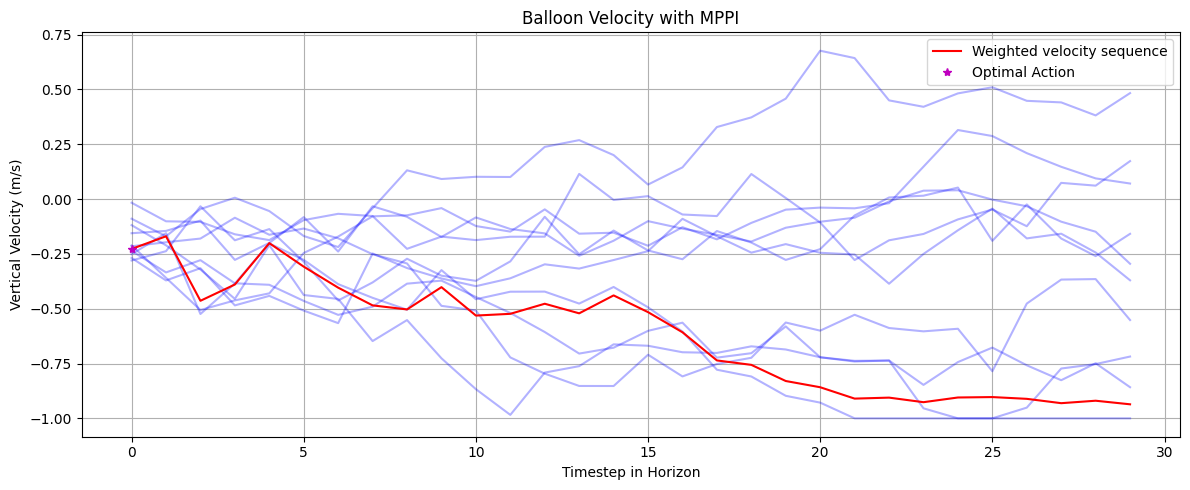

In [84]:
# 4. Compute optimal control sequence by weighted averaging
optimal_sequence = np.average(vel_samples, axis=0, weights=weights)
# Check for NaN in optimal control
if not np.isfinite(optimal_sequence[0]):
    print("Warning: NaN optimal control detected, using zero action")
    optimal_sequence[0] = 0.0

# 5. Update control sequence
control_sequence = optimal_sequence

print(f"Final control sequence: {control_sequence}")
# Plot final trajectory
plot_vels_averaged(vel_samples, control_sequence, horizon)

The graph should change slightly each time you run this section since the generated samples are random. The optimal action the agent selects is the first velocity from the control sequence.

# **Iterative Optimization**

MPPI normally optimizes once per timestep. However, we can repeat this optimization loop `num_iterations` times to try to get a better control sequence. For each loop, once we get the optimal control sequence, we pass this in as the initial control sequence to re-optimize.

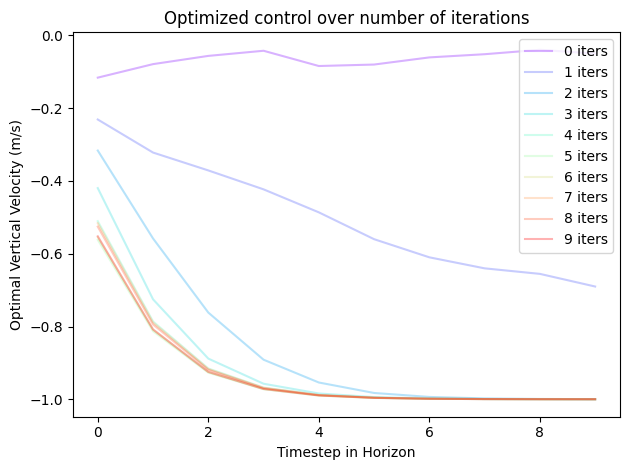

In [85]:
from matplotlib.pyplot import cm
import numpy as np

# Optional: Modify the MPPI parameters
initial_lat = 0
initial_lon = 0
initial_alt = 10.0
target_lat = 1
target_lon = 1
target_alt = 12
horizon = 10 # how long each plan is
num_samples = 10 # how many random plans should we make
num_iterations = 10 # how many times should we make the random plans
acc_bounds = -0.5,0.5
env = BalloonEnvironment(initial_lat=initial_lat, initial_lon=initial_lon, initial_alt=initial_alt, target_lat=target_lat, target_lon=target_lon,target_alt=target_alt,dt=600)
agent = MPPIAgent(horizon=horizon,num_samples=num_samples, num_iterations=num_iterations, acc_bounds=acc_bounds, visualize=False)

control_sequence = np.zeros(horizon)
first_sequence = control_sequence
color = iter(cm.rainbow(np.linspace(0, 1, agent.num_iterations)))
all_costs = []

# Repeat optimization loop
for num in range(agent.num_iterations):
  vertical_velocity = env.balloon.vertical_velocity
  base_sequence = control_sequence.copy()
  noise = np.random.normal(0, agent.noise_std, (agent.num_samples, agent.horizon))
  # Different sampling than above example
  # Decay noise over time to reduce extreme accumulation
  decay = np.linspace(1.0, 0.3, agent.horizon)
  noise *= decay

  acc_samples = base_sequence + noise
  acc_samples = np.clip(acc_samples, agent.acc_bounds[0], agent.acc_bounds[1])

  vel_samples = np.zeros_like(acc_samples)
  vel_samples[:, 0] = vertical_velocity + acc_samples[:, 0]

  for t in range(1, agent.horizon):
      vel_samples[:, t] = vel_samples[:, t - 1] + acc_samples[:, t]

  # Soft clip velocities
  vmax = agent.vel_bounds[1]
  vel_samples = np.tanh(vel_samples / vmax) * vmax
  costs = []
  for i in range(agent.horizon):
      # Evaluate one sample control sequence
      cost = 0.0
      vel_sample = vel_samples[i]
      acc_sample = acc_samples[i]

      cost, _ = agent._evaluate_control_sequence(acc_sample,vel_sample, [], env)
      costs.append(cost)

  costs = np.array(costs)
  all_costs.append(np.mean(costs))

  # Check for NaN costs and replace with high cost
  if np.any(~np.isfinite(costs)):
      print("Warning: NaN costs detected, replacing with high cost")
      costs = np.where(np.isfinite(costs), costs, 1e6)

  costs_shifted = costs - np.min(costs)
  weights = np.exp(-1 * costs_shifted)
  weights = weights / np.sum(weights)

  # Check for NaN weights
  if np.any(~np.isfinite(weights)):
      print("Warning: NaN weights detected, using uniform weights")
      weights = np.ones_like(weights) / len(weights)

  optimal_sequence = np.average(vel_samples, axis=0, weights=weights)
  # Check for NaN in optimal control
  if not np.isfinite(optimal_sequence[0]):
      print("Warning: NaN optimal control detected, using zero action")
      optimal_sequence[0] = 0.0

  control_sequence = optimal_sequence
  if num == 1:
    # Save the first optimized sequence. We will compare this to the final optimized sequence after more iterations
    first_sequence = control_sequence
  c = next(color)
  pltlabel = f"{num} iters"
  plt.plot(control_sequence, c=c, alpha=0.3, label=pltlabel)
  #print(f"Optimized control sequence: {control_sequence}")

plt.title('Optimized control over number of iterations')
plt.xlabel('Timestep in Horizon')
plt.ylabel('Optimal Vertical Velocity (m/s)')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

Try to adjust the `num_iterations` variable to see how the optimized control sequence changes! Does it seem to converge?

Below are some visualizations to see how costs and trajectories changed with these iterations.

The minimum averaged cost is 13.995901766487359
Minimum averaged cost control sequence: Plan 6


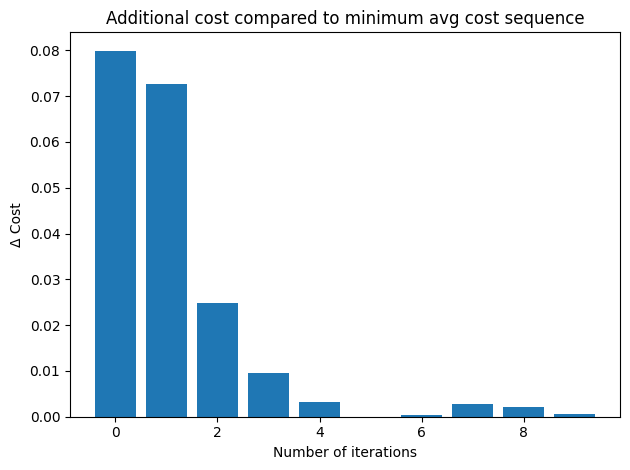

In [86]:
# Save first and last averaged cost for next section
first_cost = all_costs[0]
last_cost = all_costs[len(all_costs)-1]

# Graph differences in averaged costs
print(f"The minimum averaged cost is {min(all_costs)}")
all_costs = all_costs - min(all_costs)
all_costs = np.array(all_costs)
print(f"Minimum averaged cost control sequence: Plan {np.argmin(all_costs) + 1}")
plt.bar([i for i in range(agent.num_iterations)], all_costs)
plt.title('Additional cost compared to minimum avg cost sequence')
plt.xlabel('Number of iterations')
plt.ylabel('Δ Cost')
plt.tight_layout()
plt.show()
plt.close()

In [87]:
# Get rollouts of the first and last optimized trajectory
env.reset()
vert_movement = []
lateral_movement = []
print(f"First control sequence: {first_sequence}")
print(f"Last control sequence: {control_sequence}")
for sample in [first_sequence, control_sequence]:
  alts = []
  paths = []
  alts.append(env.balloon.alt)
  paths.append((env.balloon.lon, env.balloon.lat))
  for action in sample:
    state, reward, done, reason = env.step(action)
    alts.append(env.balloon.alt)
    paths.append((env.balloon.lon, env.balloon.lat))
  vert_movement.append(alts)
  lateral_movement.append(paths)
  env.reset() # Resetting environment to start balloon back at inital spot for next sequence to evaluate

First control sequence: [-0.23098118 -0.32182171 -0.37095971 -0.42296772 -0.48616594 -0.55994958
 -0.60980548 -0.64009695 -0.65530599 -0.69006031]
Last control sequence: [-0.55210062 -0.80795908 -0.92476849 -0.9716469  -0.98947475 -0.996115
 -0.99856902 -0.99947333 -0.99980622 -0.99992871]


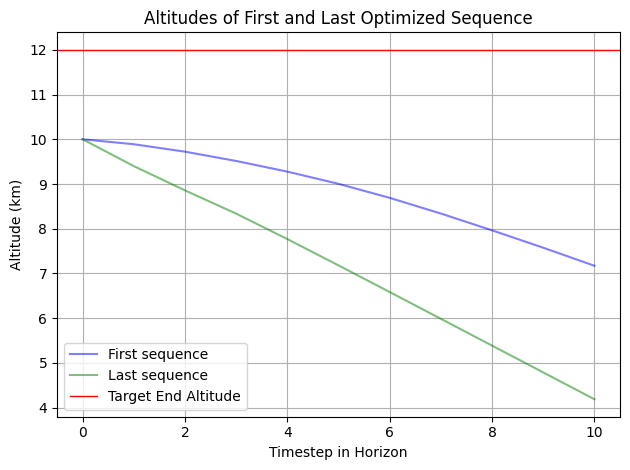

In [89]:
# Plot the movements
fig = plt.figure()
# Graph altitude of balloon
plt.plot([i for i in range(horizon + 1)], vert_movement[0], 'b-', alpha=0.5, label='First sequence')
plt.plot([i for i in range(horizon + 1)], vert_movement[1], 'g-', alpha=0.5, label='Last sequence')
target_state = [target_lat,target_lon,target_alt]
if target_state is not None:
  plt.axhline(y=target_state[2], linewidth=1, color='r', label='Target End Altitude')
  plt.legend()
plt.title(f'Altitudes of First and Last Optimized Sequence')
plt.xlabel('Timestep in Horizon')
plt.ylabel('Altitude (km)')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()


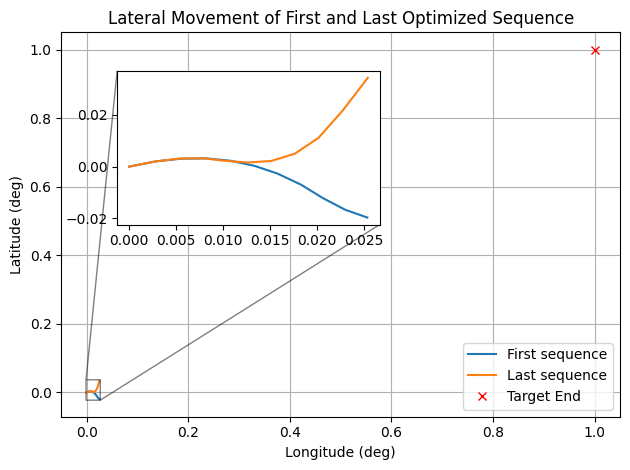

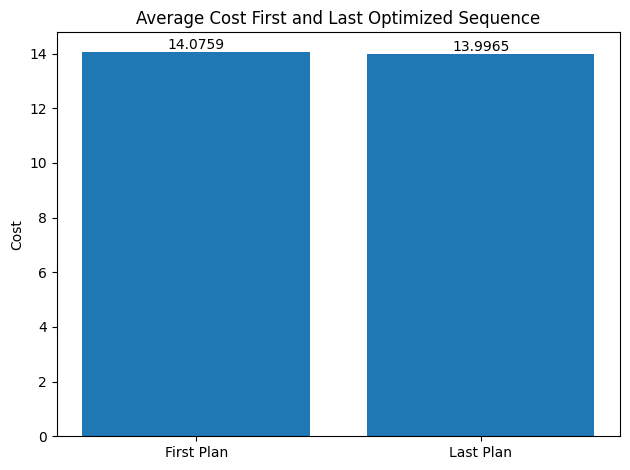

In [91]:
# Compare trajectories of first and last optimized sequences
fig, ax = plt.subplots()

lats, lons = zip(*lateral_movement[0])
ax.plot(lons, lats, label='First sequence')
lats2, lons2 = zip(*lateral_movement[1])
ax.plot(lons2, lats2, label='Last sequence')
# Plotting the target point and legend
if target_state is not None:
  ax.plot(target_state[1],target_state[0], 'rx', label='Target End')
  ax.legend(loc='lower right')
plt.title(f'Lateral Movement of First and Last Optimized Sequence')
plt.xlabel('Longitude (deg)')
plt.ylabel('Latitude (deg)')


# Inset Axes (the subgraph)
axins = ax.inset_axes([0.1, 0.5, 0.47, 0.4])
axins.plot(lons, lats)
axins.plot(lons2, lats2)
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the two costs
bars = plt.bar(['First Plan', 'Last Plan'], [first_cost, last_cost])
plt.bar_label(bars, [f"{first_cost:.4f}", f"{last_cost:.4f}"])
plt.title(f'Average Cost First and Last Optimized Sequence')
plt.ylabel('Cost')
plt.tight_layout()
plt.show()
plt.close()